File loaded correctly!
Shape: (9648, 13)


,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,600000.0,300000.0,0.50,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,500000.0,150000.0,0.30,In-store
2,Foot Locker,1185732,2020-01-03,Northeast,New York,New York,Women's Street Footwear,40.0,1000,400000.0,140000.0,0.35,In-store
3,Foot Locker,1185732,2020-01-04,Northeast,New York,New York,Women's Athletic Footwear,45.0,850,382500.0,133875.0,0.35,In-store
4,Foot Locker,1185732,2020-01-05,Northeast,New York,New York,Men's Apparel,60.0,900,540000.0,162000.0,0.30,In-store


price_per_unit: 104 outliers (kept for analysis)
units_sold: 508 outliers (kept for analysis)
total_sales: 653 outliers (kept for analysis)
operating_profit: 706 outliers (kept for analysis)
operating_margin: 63 outliers (kept for analysis)

--- Basic Statistical Summary ---
                   count          mean            std  min        25%  \
price_per_unit    9648.0     45.216625      14.705397  7.0    35.0000   
units_sold        9648.0    256.930037     214.252030  0.0   106.0000   
total_sales       9648.0  93273.437500  141916.016727  0.0  4254.5000   
operating_profit  9648.0  34425.244761   54193.113713  0.0  1921.7525   
operating_margin  9648.0      0.422991       0.097197  0.1     0.3500   

                      50%        75%       max  
price_per_unit      45.00      55.00     110.0  
units_sold         176.00     350.00    1275.0  
total_sales       9576.00  150000.00  825000.0  
operating_profit  4371.42   52062.50  390000.0  
operating_margin     0.41       0.49    

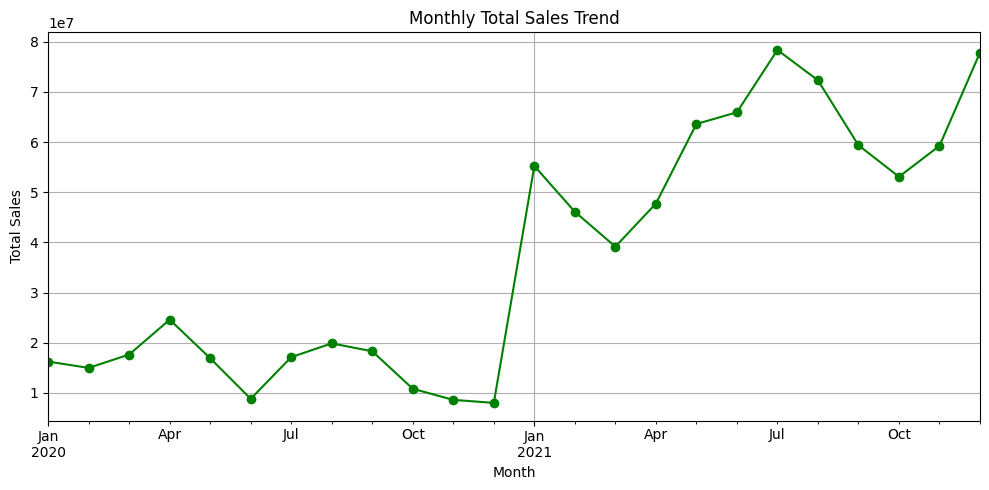

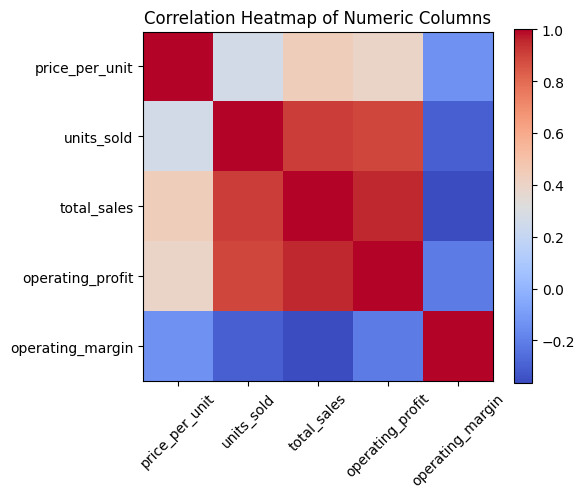

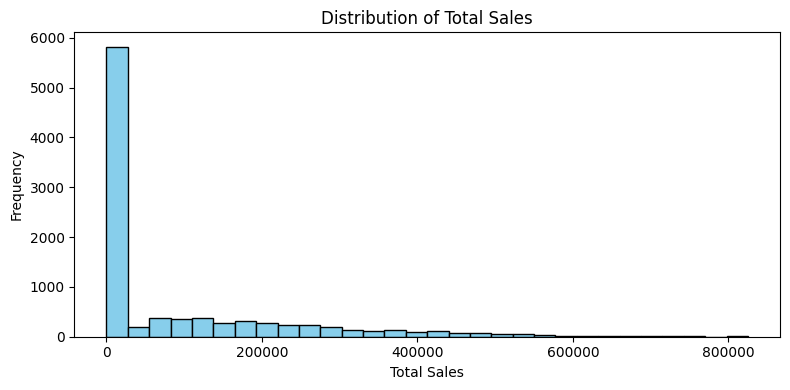

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and Clean Dataset
df = pd.read_excel(
    'Adidas US Sales Datasets.xlsx',
    skiprows=4,                     # remove metadata rows
    usecols=lambda c: c != 'Unnamed: 0'  # skip useless first column
)

print("File loaded correctly!")
print("Shape:", df.shape)
display(df.head())

# 2. Clean Column Names for PostgreSQL
df.columns = (
    df.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.lower()
)

# 3. Handle Missing and Duplicates
df.drop_duplicates(inplace=True)
df.fillna({
    'operating_margin': df['operating_margin'].median(),
    'sales_method': 'Unknown'
}, inplace=True)

# 4. Data Type Correction
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')

numeric_cols = [
    'price_per_unit', 'units_sold', 'total_sales',
    'operating_profit', 'operating_margin'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 5. Derive Date Columns (for SQL analysis)
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month_name()

# 6. Outlier Detection
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"{col}: {outliers} outliers (kept for analysis)")

# 7. Simple Statistical Analysis

print("\n--- Basic Statistical Summary ---")
print(df[numeric_cols].describe().T)

print("\n--- Mean, Median, Mode ---")
for col in numeric_cols:
    mean_val = df[col].mean()
    median_val = df[col].median()
    mode_val = df[col].mode()[0]
    print(f"{col}: mean={mean_val:.2f}, median={median_val:.2f}, mode={mode_val:.2f}")

print("\n--- Correlation Matrix ---")
print(df[numeric_cols].corr())

# Additional Insights
total_revenue = df['total_sales'].sum()
total_profit = df['operating_profit'].sum()
average_margin = df['operating_margin'].mean()
average_price = df['price_per_unit'].mean()
average_units = df['units_sold'].mean()

print("\n--- Key Business Metrics ---")
print(f"Total Revenue: {total_revenue:,.2f}")
print(f"Total Profit: {total_profit:,.2f}")
print(f"Average Operating Margin: {average_margin:.2f}")
print(f"Average Price per Unit: {average_price:.2f}")
print(f"Average Units Sold per Transaction: {average_units:.2f}")

# Top 5 Retailers by Total Sales
print("\nTop 5 Retailers by Total Sales:")
print(df.groupby('retailer')['total_sales'].sum().sort_values(ascending=False).head(5))

# 8. Export Clean CSV
df.to_csv('adidas_for_sql.csv', index=False)
print("\nPostgreSQL-ready file saved as 'adidas_for_sql.csv'")

# 9. Quick EDA Summaries
print("\nSummary by Region:")
print(df.groupby('region')['total_sales'].sum().sort_values(ascending=False))

print("\nSummary by Product:")
print(df.groupby('product')['total_sales'].sum().sort_values(ascending=False).head(10))

# 10. Visualization Section

# Monthly Sales Trend
monthly_sales = df.groupby(df['invoice_date'].dt.to_period('M'))['total_sales'].sum()
plt.figure(figsize=(10,5))
monthly_sales.plot(marker='o', color='green')
plt.title('Monthly Total Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation Plot for Numeric Features
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap of Numeric Columns")
plt.tight_layout()
plt.show()

# Distribution Plot for Total Sales
plt.figure(figsize=(8,4))
plt.hist(df['total_sales'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
